# Notebook to generate Fig-3 in supplementary material for the manuscrip " Implicit regularization in Heavy-ball momentum accelerated stochastic gradient descent "

Consider loss function with two learnable raviables $w_1,w_2$: $E(w_1,w_2)=\frac{1}{2}(y-\frac{w_1}{1+e^{-w_2*x}})^2$

Gradient: $\nabla E_{w_1}=\frac{1}{1+e^{-w_2x}}(\frac{w_1}{1+e^{-w_2x}}-y)$, $\nabla E_{w_2}=\frac{w_1xe^{-w_2 x}}{(1+e^{-w_2x})^2}(\frac{w_1}{1+e^{-w_2x}}-y)$

Squared norm of grad: $\|\nabla E\|^2=(\frac{1}{(1+e^{-w_2x})^2}+\frac{w_1^2x^2e^{-2w_2x}}{(1+e^{-w_2x})^4})(\frac{w_1}{1+e^{-w_2x}}-y)^2$

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch

## Define trajectories based on (GD) and (GD+M) update

In [18]:
## GD
def traj_g(hs,a2,b2,T):
    a1,b1,a0,b0 = a2,b2,a2,b2
    as_history,bs_history = [a0,a1],[b0,b1]
    grad_history = []
    grad_norm_history = []
    for i in range(T):
        at,bt = a1,b1
        a1 = a1 - hs*((at/(1+np.exp(-bt*x))-y))/(1+np.exp(-bt*x))
        b1 = b1 - hs*at*x*np.exp(-bt*x)*(at/(1+np.exp(-bt*x))-y)/(1+np.exp(-bt*x))**2
        a0,b0 = at,bt
        as_history.append(a1)
        bs_history.append(b1)
        grad_history.append(comp_grad_norm(a1,b1))
        grad_norm_history.append(grad_norm(a1,b1))
    return as_history,bs_history,grad_history,grad_norm_history

##GD+M
def traj_gm(hs,a2,b2,T,beta=0.9):
    hm = hs*(1-beta) ##effective l.r same as GD
    a1,b1,a0,b0,beta = a2,b2,a2,b2,beta
    am_history,bm_history = [a0,a1],[b0,b1]
    grad_history = []
    grad_norm_history = []
    for i in range(T):
        at,bt = a1,b1
        a1 = a1 - hm*(at/(1+np.exp(-bt*x))-y)/(1+np.exp(-bt*x)) + beta*(a1-a0)
        b1 = b1 - hm*at*x*np.exp(-bt*x)*(at/(1+np.exp(-bt*x))-y)/(1+np.exp(-bt*x))**2 + beta*(b1-b0)
        a0,b0 = at,bt
        am_history.append(a1)
        bm_history.append(b1)
        grad_history.append(comp_grad_norm(a1,b1))
        grad_norm_history.append(grad_norm(a1,b1))
    return am_history,bm_history,grad_history, grad_norm_history
    
# Compute the squared gradient norm
def comp_grad_norm(a,b):
  return ((a/(1+np.exp(-b*x))-y)/(1+np.exp(-b*x)))**2+(a*x*np.exp(-b*x)*(a/(1+np.exp(-b*x))-y)/(1+np.exp(-b*x))**2)**2

## Create trajectories with same effective learning rate for beta=0, 0.5, 0.8, and 0.9

In [19]:
x,y = 1,0.6  
hss = 1e-5
hs =1e-2   ## learning-rate
#beta = 0.9  ## momentum parameter
T = 2000  ##time iterations

##initialization
a_init,b_init = 6,2  

ass_history,bss_history,grad_history,grad_norm_history = traj_g(hss,a_init,b_init,1500000) # we use very small lr hss so the trajectory represents the gradient flow 
as_history,bs_history,grad_history,grad_norm_history = traj_g(hs,a_init,b_init,T)
am_history_09,bm_history_09,grad_history_09,grad_norm_history_09 =  traj_gm(hs,a_init,b_init,T,beta=0.9)
am_history_08,bm_history_08,grad_history_08,grad_norm_history_08 =  traj_gm(hs,a_init,b_init,T,beta=0.8)
am_history_05,bm_history_05,grad_history_05,grad_norm_history_05 =  traj_gm(hs,a_init,b_init,T,beta=0.5)

### Create the gradient flow minimizing implicit regularizer $\|\nabla E\|^2$


In [20]:
def traj_g_torch(hs,T):
  a,b = torch.tensor(6.,requires_grad=True,device=device),torch.tensor(2.,requires_grad=True,device=device)
  x,y = torch.tensor(1),torch.tensor(0.6)
  as_history,bs_history = [],[]
  print("Started, it will take about 8 mins")
  for epoch in range(T):
    loss = ((a/(1+torch.exp(-b*x))-y)/(1+torch.exp(-b*x))).pow(2)+(a*x*torch.exp(-b*x)*(a/(1+torch.exp(-b*x))-y)/(1+torch.exp(-b*x)).pow(2)).pow(2)
    loss.backward()
    with torch.no_grad():
      a -= hs*a.grad
      b -= hs*b.grad
      as_history.append(a.item())
      bs_history.append(b.item())
      a.grad.zero_()
      b.grad.zero_()
  return as_history,bs_history


T = 1000000
device = torch.device("cpu") 
ass_reg_history,bss_reg_history = traj_g_torch(hs=1e-5,T=T)

Started, it will take about 10 mins


## Plot the trajectories 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


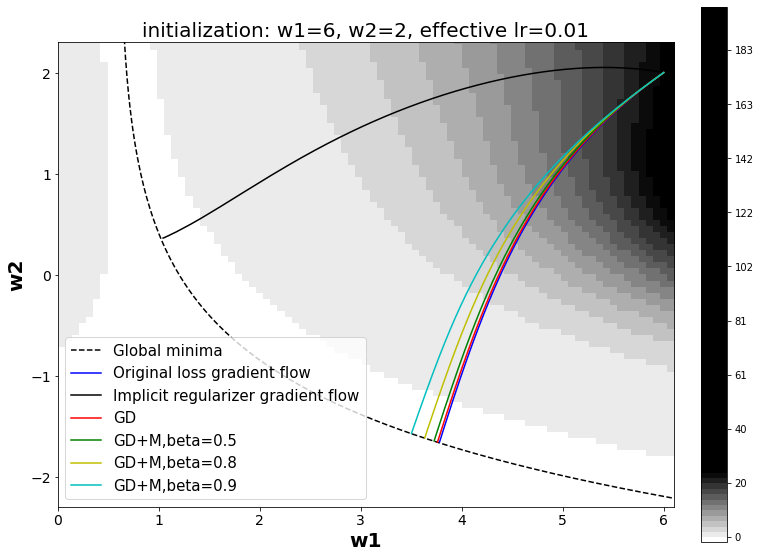

In [24]:
import torch 
from google.colab import files
import matplotlib.colors as colors
import numpy as np

# Global minima 
a = np.linspace(0.01,15,1000)
if torch.is_tensor(x):
  x,y = x.item(),y.item()
b = -np.log(a/y-1)/x

x_grid = np.linspace(0,7,101)
y_grid = np.linspace(-3,3,101)

# Create contour for gradient norm
imp = np.zeros((len(y_grid)-1,len(x_grid)-1))
for i in range(len(x_grid)-1):
   for j in range(1, len(y_grid)):
     imp[-j,i] = comp_grad_norm(x_grid[i],y_grid[j])

extent=(0,7,-3,3)
plt.figure(figsize=(12,12))
plt.plot(a,b,color='w')
bounds = np.linspace(-2, 200, 100)
bounds = np.array(list(bounds))
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=2000)
plt.imshow((imp),cmap='binary', norm = norm, extent=extent)
plt.colorbar(format='%d', fraction=0.04, pad=0.04)


plt.plot(a,b,color ='black', linestyle='dashed',label ='Global minima')
plt.plot(ass_history,bss_history,'b',label='Original loss gradient flow')
plt.plot(ass_reg_history,bss_reg_history,'k',label='Implicit regularizer gradient flow')
plt.plot(as_history,bs_history,'r',label='GD')
plt.plot(am_history_05,bm_history_05,'g',label='GD+M,beta=0.5')
plt.plot(am_history_08,bm_history_08,'y',label='GD+M,beta=0.8')
plt.plot(am_history_09,bm_history_09,'c',label='GD+M,beta=0.9')
plt.legend(fontsize=15)
plt.xlim([0,6.1])
plt.ylim([-2.3,2.3])
plt.xlabel("w1", fontsize=20,fontweight='bold')
plt.ylabel("w2", fontsize=20,fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'initialization: w1={a_init}, w2={b_init}, effective lr={hs}',fontsize=20)
#plt.savefig("hyperbola.png",dpi=2000)
plt.savefig("sigmoid.png")
files.download("sigmoid.png") 